In [1]:
import numpy as np
import pandas as pd
from functools import reduce
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller
from scipy import signal
%matplotlib inline

# If you want a style choose one
plt.style.use('Solarize_Light2')
#plt.style.use('tableau-colorblind10')
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'

In [2]:
# Preparing the final DataFrame
df_price = pd.read_csv(r'data\da_prices\GUI_ENERGY_PRICES_202412312300-202512312300_UTC.csv')
df_load = pd.read_csv(r'data\load\GUI_TOTAL_LOAD_DAYAHEAD_202412312300-202512312300.csv')
df_off_wind = pd.read_csv(r'data\res\off_wind\GUI_WIND_SOLAR_GENERATION_FORECAST_OFFSHORE_202412312300-202512312300.csv')
df_on_wind = pd.read_csv(r'data\res\on_wind\GUI_WIND_SOLAR_GENERATION_FORECAST_ONSHORE_202412312300-202512312300.csv')
df_solar = pd.read_csv(r'data\res\solar\GUI_WIND_SOLAR_GENERATION_FORECAST_SOLAR_202412312300-202512312300.csv')
df_total_gen = pd.read_csv(r'data\total_gen_forecast_da\GUI_TOTAL_GENERATION_FORECAST_202412312300-202512312300.csv')

In [3]:
# Function to add :00 seconds to the HH:MM format

import re

def fix_dst_string(text):
    if not isinstance(text, str):
        return text
    
    # This regex finds a time HH:MM (\d{2}:\d{2}) 
    # but ONLY if it is NOT already followed by :SS
    # and adds :00. It preserves trailing text like (CET).
    return re.sub(r'(\d{2}:\d{2})(?!:\d{2})', r'\1:00', text)

# Apply to df_load
df_load['MTU (CET/CEST)'] = df_load['MTU (CET/CEST)'].apply(fix_dst_string)

In [4]:
# 1. Rename the columns to have them unique across all DataFrames (except the key)
df_price = df_price.rename(columns={
    'Day-ahead Price (EUR/MWh)': 'price', 'MTU (CET/CEST) End UTC': 'timestamp_utc'})
df_load = df_load.rename(columns={ 
    'Actual Total Load (MW)': 'load_actual',
    'Day-ahead Total Load Forecast (MW)': 'load_forecast_da'})
df_off_wind = df_off_wind.rename(columns={
    'Day-ahead (MW)': 'off_wind_da',
    'Actual (MW)': 'off_wind_act'})
df_on_wind = df_on_wind.rename(columns={
    'Day-ahead (MW)': 'on_wind_da',
    'Actual (MW)': 'on_wind_act'})
df_solar = df_solar.rename(columns={
    'Day-ahead (MW)': 'solar_da',
    'Actual (MW)': 'solar_act'})
df_total_gen = df_total_gen.rename(columns={
    'Generation Forecast (MW)': 'gen_forecast_da',
    'Actual Generation (MW)': 'gen_actual'})

# 2. Define the key
key = "MTU (CET/CEST)"

# 3. Define exactly which columns you want from each DataFrame
# (Excluding the key, as we will add that back in automatically)
target_columns = {
    "price": ['price', 'timestamp_utc'],
    "load": ["load_actual", "load_forecast_da"],
    "off_wind": ["off_wind_da", "off_wind_act"],
    "on_wind": ["on_wind_da", "on_wind_act"],
    "solar": ["solar_da", "solar_act"],
    "total_gen": ["gen_forecast_da", "gen_actual"]
}

# 3. Create a list of DataFrames filtered to ONLY those columns + the key
# We start with df_price as the base
filtered_dfs = [df_price[[key] + target_columns["price"]]]

# Add the others dynamically
data_map = {
    "load": df_load, "off_wind": df_off_wind, "on_wind": df_on_wind, 
    "solar": df_solar, "total_gen": df_total_gen
}

for name, df in data_map.items():
    cols_to_keep = [key] + target_columns[name]
    # Filter the DF and add to our list
    filtered_dfs.append(df[cols_to_keep])

# 4. Perform the reduce merge
df_total = reduce(
    lambda left, right: pd.merge(left, right, on=key, how="left"),
    filtered_dfs
)
df_total.head()

,MTU (CET/CEST),price,timestamp_utc,load_actual,load_forecast_da,off_wind_da,off_wind_act,on_wind_da,on_wind_act,solar_da,solar_act,gen_forecast_da,gen_actual
0,01/01/2025 00:00:00 - 01/01/2025 00:15:00,2.16,2024-12-31T23:15,48899.61,45881.13,3742.06,2415.09,38289.70,32973.68,0.0,9.97,56958.77,54364.42
1,01/01/2025 00:15:00 - 01/01/2025 00:30:00,2.16,2024-12-31T23:30,48018.91,45230.07,3756.45,2601.31,38511.97,32832.53,0.0,9.32,56351.59,54352.05
2,01/01/2025 00:30:00 - 01/01/2025 00:45:00,2.16,2024-12-31T23:45,48048.26,44700.95,3763.86,2542.27,38706.47,32832.18,0.0,9.37,56269.29,53669.64
3,01/01/2025 00:45:00 - 01/01/2025 01:00:00,2.16,2025-01-01T00:00,47918.90,44062.82,3776.26,2450.01,38869.75,32895.95,0.0,9.56,56507.27,53384.97
4,01/01/2025 01:00:00 - 01/01/2025 01:15:00,1.60,2025-01-01T00:15,47667.03,43302.48,3784.38,2252.60,38917.29,33260.24,0.0,9.93,56223.26,54173.60


In [5]:
# Dealing with missing values in exogenous variables
df_total['solar_da'] = df_total['solar_da'].fillna(0)
df_total['on_wind_da'] = df_total['on_wind_da'].interpolate(method='linear')

Text(0.5, 1.0, 'Day-Ahead Energy Prices in December 2025')

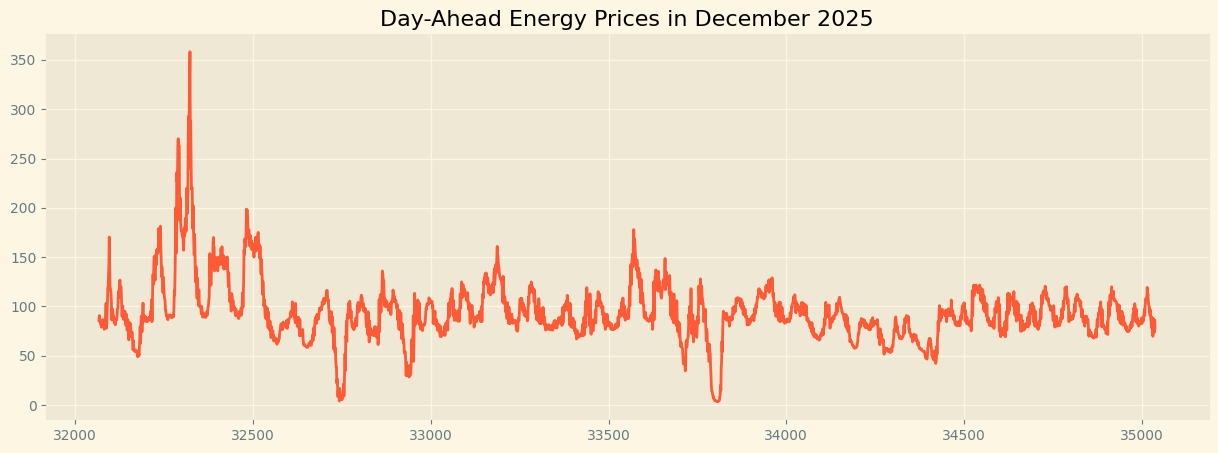

In [6]:
df_total[df_total['timestamp_utc'] >= '2025-12-01T00:00']['price'].plot(figsize=(15, 5), color=NF_ORANGE)
plt.title('Day-Ahead Energy Prices in December 2025')

## SARIMAX ##

In [7]:
# Ensure timestamp index
df_total["timestamp_utc"] = pd.to_datetime(df_total["timestamp_utc"])
df_total = df_total.set_index("timestamp_utc").sort_index()

In [8]:
# Resample to hourly
df_total = df_total.drop('MTU (CET/CEST)', axis =1)
df_total = df_total.resample('H').mean()
df_total = df_total.asfreq("H")
print(df_total.isna().sum())

price               0
load_actual         0
load_forecast_da    0
off_wind_da         0
off_wind_act        0
on_wind_da          0
on_wind_act         0
solar_da            0
solar_act           0
gen_forecast_da     0
gen_actual          0
dtype: int64


In [9]:
# Target
y = df_total["price"]

# Exogenous variables
exog = df_total[["load_forecast_da", "off_wind_da", "on_wind_da", "solar_da"]]

In [10]:
exog.isna().sum()

load_forecast_da    0
off_wind_da         0
on_wind_da          0
solar_da            0
dtype: int64

In [11]:
# print(f"Rows before: {len(df_total)}")
# df_total = df_total.asfreq("H")
# print(f"Rows after: {len(df_total)}")

In [18]:
# Train / test split
split_date = "2025-12-01"
begin_date = "2025-11-25"
end_date = "2025-12-05"

y_train = y[:split_date]
y_test  = y[split_date:]

exog_train = exog[:split_date]
exog_test  = exog[split_date:]


In [13]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set the frequency explicitly
#y_train = y_train.asfreq('15T')
#exog_train = exog_train.asfreq('15T')

# Now run the SARIMAX model

model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(1,0,1),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit()
print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                              price   No. Observations:                 8041
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              -30998.495
Date:                            Thu, 05 Feb 2026   AIC                          62014.990
Time:                                    18:41:54   BIC                          62077.892
Sample:                                12-31-2024   HQIC                         62036.518
                                     - 12-01-2025                                         
Covariance Type:                              opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
load_forecast_da     0.0030    3.1e-05     97.848      0.000       0.003       0.003
off_wind_da      

Text(0.5, 1.0, 'SARIMAX Forecast of Day-Ahead Energy Prices (Next 24 Hours)')

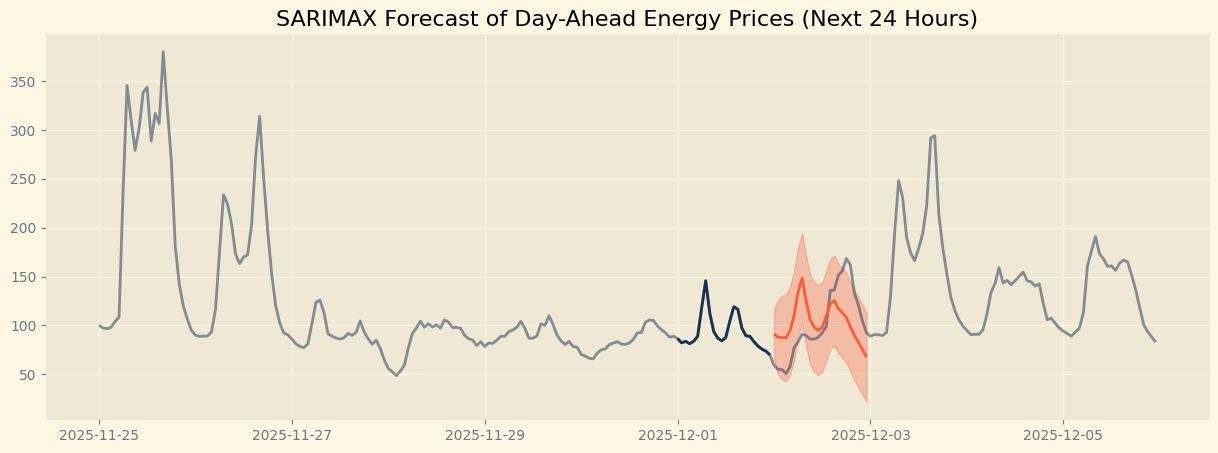

In [21]:
# Forecast next-day hourly prices

n_steps = 24

forecast = results.get_forecast(
    steps=n_steps,
    exog=exog_test.iloc[:n_steps]
)

y_pred = forecast.predicted_mean
conf_int = forecast.conf_int()
# Plotting actual curne and the results

y_slice = y[begin_date:end_date]

plt.figure(figsize=(15, 5))
plt.plot(y_slice.index, y_slice, label='Historical', color=NF_BLUE, alpha=0.5)
plt.plot(y_test.index[:n_steps], y_test[:n_steps], label='Actual', color=NF_BLUE)
plt.plot(y_pred.index, y_pred, label='Predicted', color=NF_ORANGE)
plt.fill_between(conf_int.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color=NF_ORANGE, alpha=0.3, label='Confidence Interval')
plt.title('SARIMAX Forecast of Day-Ahead Energy Prices (Next 24 Hours)')